# Séries chronologiques avec tensorflow 

Source : [https://www.tensorflow.org/tutorials/structured_data/time_series?hl=fr](https://www.tensorflow.org/tutorials/structured_data/time_series?hl=fr)

Data set téléchargé depuis : 

[https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip](https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip)

In [1]:
import os, datetime,time

from IPython.display import Image, display
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image as PILImage

mpl.rcParams['figure.figsize'] = (6,5)
mpl.rcParams['axes.grid'] = False


2024-12-01 15:30:23.280814: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#petit helper pour ajouter fond blanc aux images 
def ajouter_fond(name:str)->None:
    img = PILImage.open(name)
    bg = PILImage.new("RGB", img.size, (255, 255, 255))
    bg.paste(img, mask=img.split()[3] if img.mode == 'RGBA' else None)
    bg.save(name)
def show_image(name):
    img = mpimg.imread(name)  
    plt.imshow(img)
    plt.axis('off')
    plt.show()
ajouter_fond('plusieurs_pas.png')

### Import des données, sous données, données manquantes

In [3]:
df = pd.read_csv('jena_climate_2009_2016.csv')
df.head(2)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1


In [4]:
#On fait des extractions ici, à partir de la donnée 5, prendre une donnée tous les 6 intervals de temps
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


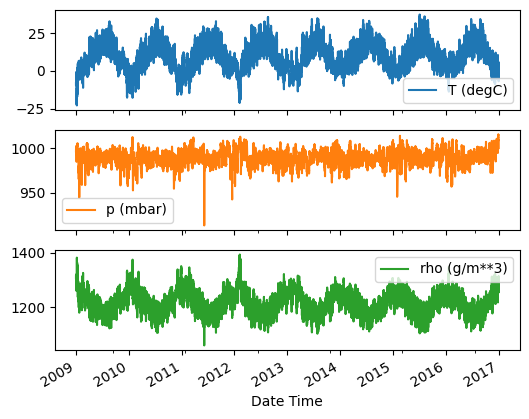

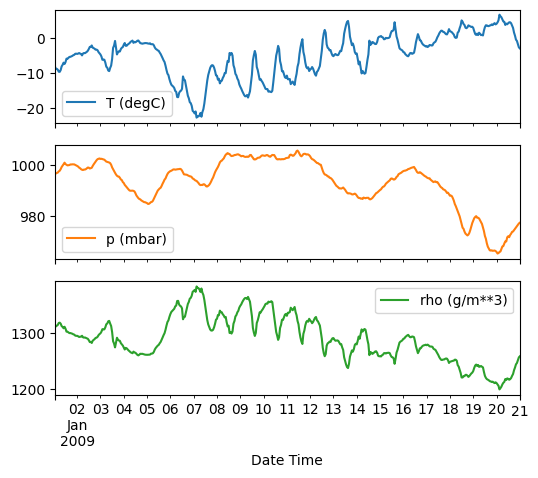

In [5]:
#Tracés de quelques caractères au fil du temps
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [6]:
#Description des données 
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


In [7]:
#On relève deux anomalies sur les vitesses de vent (wv, maw. wv), on les corrige en remplaçant par 0
wv=df['wv (m/s)']
bad=wv==-9999.0
wv[bad]=0.0
max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0
#les modifications sont faites dans le dataset (inplace)
df['wv (m/s)'].min()

np.float64(0.0)

### Un peu d'ingénierie des données

Text(0, 0.5, 'Wind Velocity [m/s]')

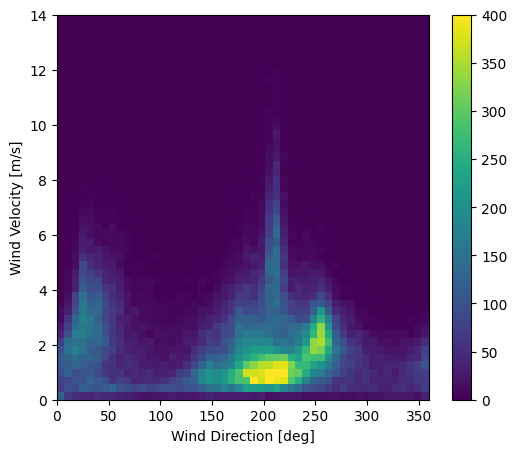

In [8]:
# les composantes de vent (direction,vistesse)
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

(np.float64(-11.305513973134667),
 np.float64(8.24469928549079),
 np.float64(-8.27438540335515),
 np.float64(7.7338312955467785))

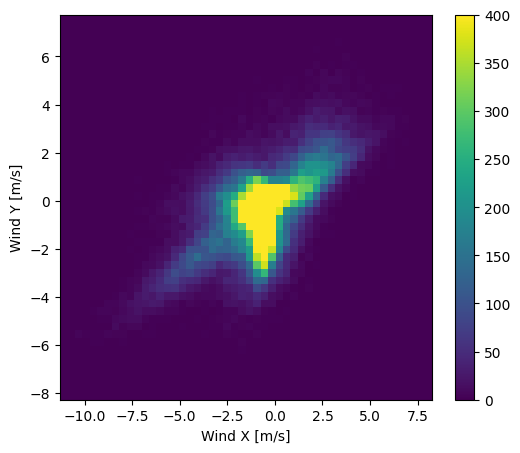

In [9]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Conversion en radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# coordonnées x et y du vent.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calcul min et max en x et en y.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

Text(0.5, 1.0, 'Time of day signal')

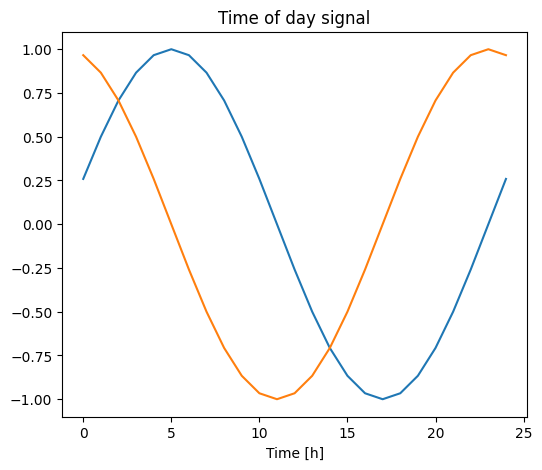

In [10]:
# Conversion datetime en secondes : 
timestamp_s = date_time.map(pd.Timestamp.timestamp)
#Représentation jours et secondes sous forme de sinusoïdes
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

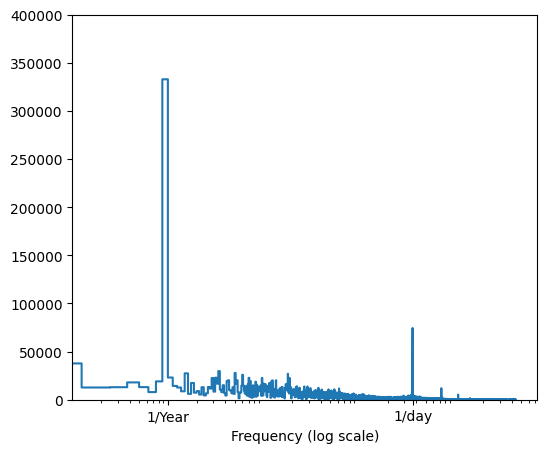

In [11]:
#Représentation des composantes de fourier de la température, ce qui donne ses échelles principales de variabilité en temps
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [12]:
#train val test split des données
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [13]:
#Normalisation des données (comme avec StandardScaler de scikit-learn)
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

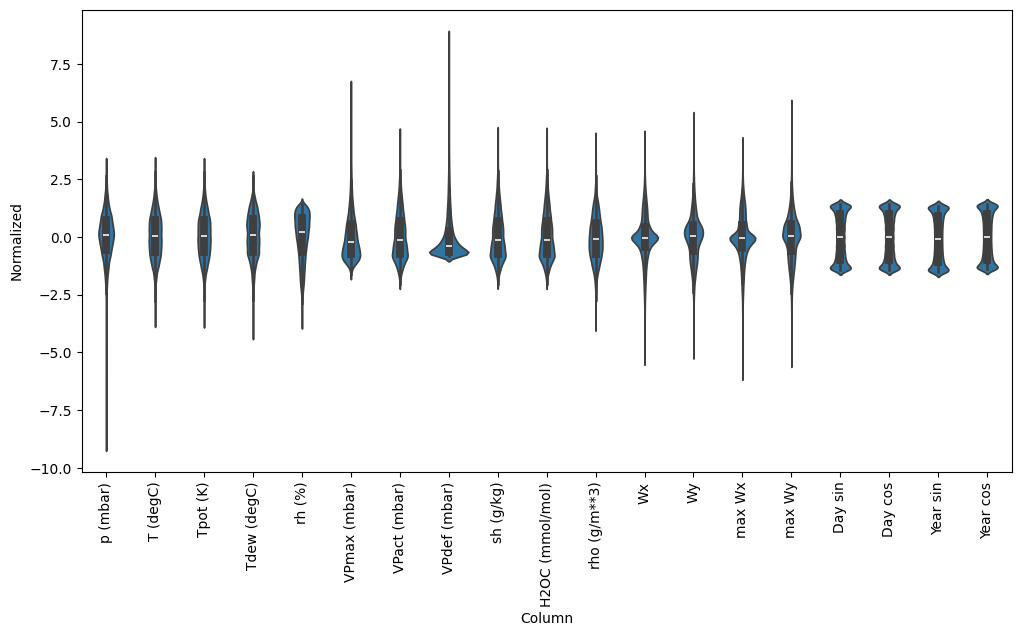

In [14]:
#On peut se représenter la distribution des caractères normalisés avec un violin plot
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
ax.set_xticks(range(len(df.keys())))
_=ax.set_xticklabels(df.keys(), rotation=90)
plt.show()

### Le fenêtrage, essentiel pour l'apprentissage des séries chronologiques :

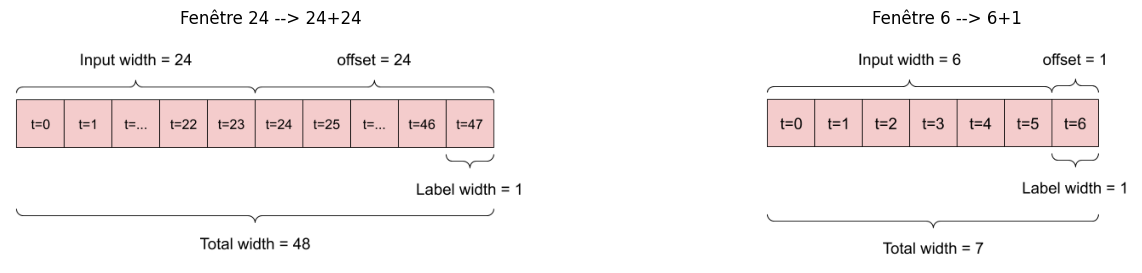

In [15]:
img1 = mpimg.imread('fenetrage.png')  
img2 = mpimg.imread('fenetrage_6_1.png')  
fig, axes = plt.subplots(1, 2, figsize=(16, 3))  # 1 row, 2 columns
axes[0].imshow(img1)
axes[0].axis('off')  # Hide axes
axes[0].set_title("Fenêtre 24 --> 24+24")
axes[1].imshow(img2)
axes[1].axis('off')  # Hide axes
axes[1].set_title("Fenêtre 6 --> 6+1")
plt.show()

In [16]:
# La classe WindowGenerator
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Stockage des données train,val,test
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    # On fait des dicos qui renvoient aux noms de colonnes leurs indices
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}
    # On stock les caractéristiques de la fenêtre 
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift
    self.total_window_size = input_width + shift
    #on définit pour la fenêtre les indices d'inputs, et de labels
    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [17]:
#Exemples correspondant aux deux fenêtres de la figure ci-dessus: 
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,label_columns=['T (degC)'])
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,label_columns=['T (degC)'])


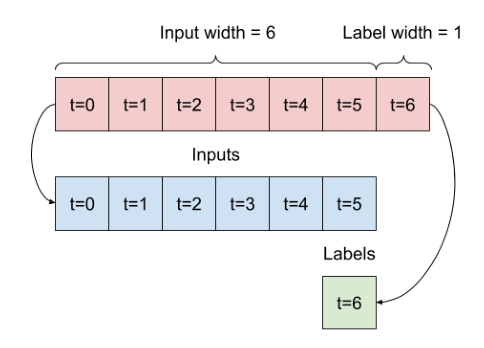

In [18]:
#On aura besoin de diviser
show_image('diviser_6_1.png')

In [19]:
#On ajoute une méthode à notre objet : 
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns],axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])
  return inputs, labels

WindowGenerator.split_window = split_window

Le code ci-dessous prend un lot de trois fenêtres à 7 pas de temps avec 19 fonctionnalités à chaque pas de temps. Il les divise en un lot d'entrées de 19 caractéristiques à 6 pas de temps et une étiquette de 1 caractéristique à 1 pas de temps. L'étiquette n'a qu'une seule fonctionnalité car le WindowGenerator a été initialisé avec label_columns=['T (degC)'] . Dans un premier temps, ce didacticiel créera des modèles qui prédisent des étiquettes de sortie uniques.

In [20]:
#Exemple de fonctionnement
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')
#On ajoute à notre fenêtre w2 un attribut example : 
w2.example = example_inputs, example_labels

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


In [21]:
#On ajoute la méthode plot a notre WindowGenerator : 
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(16, 6))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)
    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index
    if label_col_index is None:
      continue
    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
    if n == 0:
      plt.legend()
  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

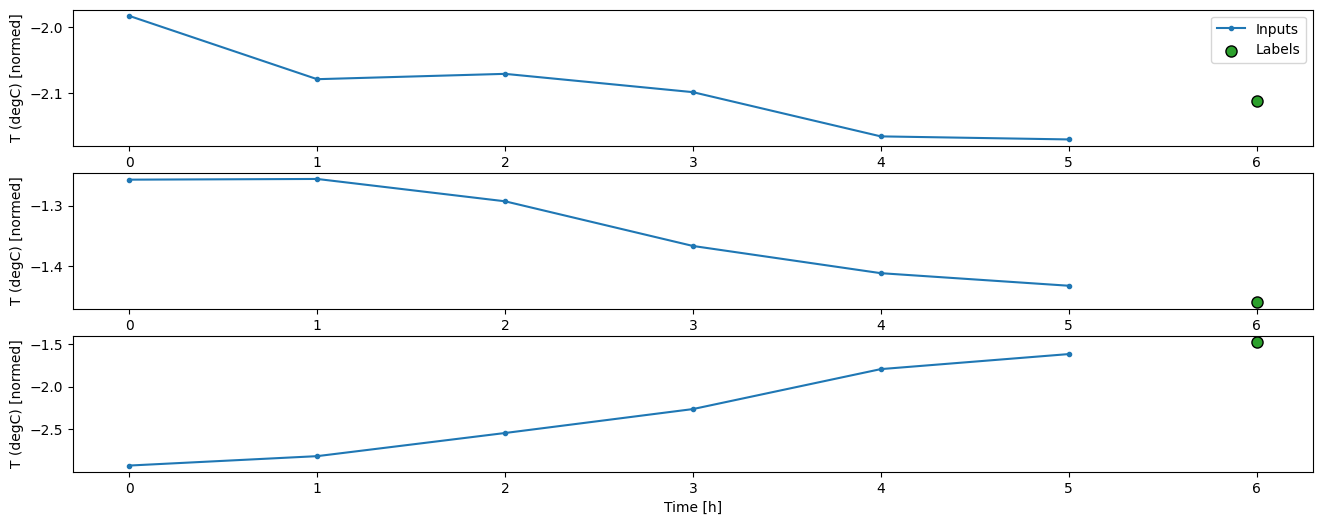

In [22]:
w2.plot()

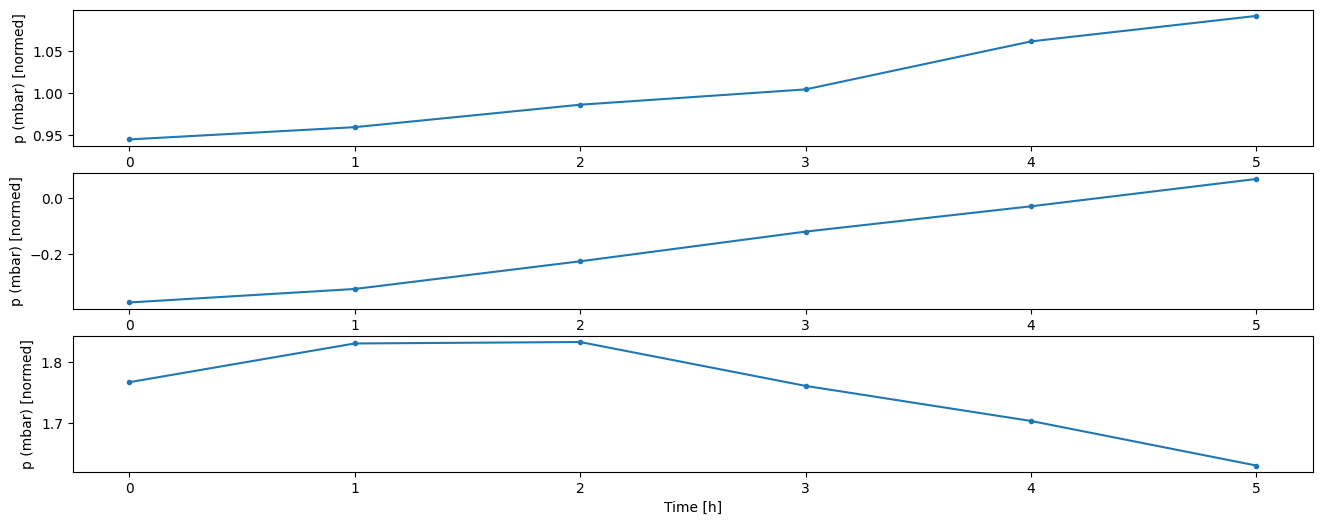

In [23]:
#Si la colonne n'est pas dans les labels, il n'y a pas de label qui s'affiche (ici fenêtre 6_1, position de label = index 6)
w2.plot(plot_col='p (mbar)')

In [24]:
# la méthode make_dataset prendra une série chronologique DataFrame et la convertira en un tf.data.Dataset de paires (input_window, label_window) à 
# #l'aide de la fonction tf.keras.utils.timeseries_dataset_from_array
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [25]:
#On ajoute des propriétés à l'aide des décorateurs @property, générant des Dataset (keras) à partir de train,val,test
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [26]:
#La propriété "element_spec" sur train, val, test donne les dimensions caractéristiques des Dataset
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

### Prédictions 1 : prédire la donnée suivante 

In [27]:
#helper pour synthétiser l'entra^nement des modèles à suivre : 
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  tic=time.time()
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  elapsed=f"Elapsed for compile and fit ={time.time()-tic}s."
  return history,elapsed

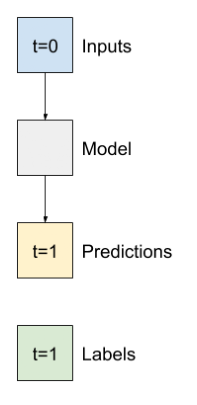

In [28]:
show_image('narrow_window.png')

In [29]:
# Pour ce type de modèle, on crée un windowgenerator avec 1 entrée, 1 sortie, un shift de 1
single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1,label_columns=['T (degC)'])
print(single_step_window)
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')


Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']
Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


2024-12-01 15:30:37.626403: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#### Modèle Baseline : on renvoie la valeur courante

In [ ]:
#Pour avoir une idée de la performance d'un modèle de prédiction éventuel, on va commencer par construire un prédicteur 
# qui se contente de renvoyer la valeur présente comme valeur future
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]
  
baseline = Baseline(label_index=column_indices['T (degC)'])

history,elapsed=compile_and_fit(baseline,single_step_window)
# baseline.compile(loss=tf.losses.MeanSquaredError(),
#                  metrics=[tf.metrics.MeanAbsoluteError()])
IPython.display.clear_output()
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)
print(elapsed)

Epoch 1/20
  55/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0133 - mean_absolute_error: 0.080108

/home/lacroix/Bureau/Documents/enseignement/electif_3A/2023_2024/torch/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0137 - mean_absolute_error: 0.0821 - val_loss: 0.0128 - val_mean_absolute_error: 0.0785
Epoch 2/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0136 - mean_absolute_error: 0.0820 - val_loss: 0.0128 - val_mean_absolute_error: 0.0785
Epoch 3/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0136 - mean_absolute_error: 0.0821 - val_loss: 0.0128 - val_mean_absolute_error: 0.0785
Epoch 4/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0136 - mean_absolute_error: 0.0820 - val_loss: 0.0128 - val_mean_absolute_error: 0.0785
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0128 - mean_absolute_error: 0.0788
Elapsed for compile and fit =13.669698715209961s.


In [31]:
# On fait une fenêtre plus large pour une prévision baseline de 24h
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

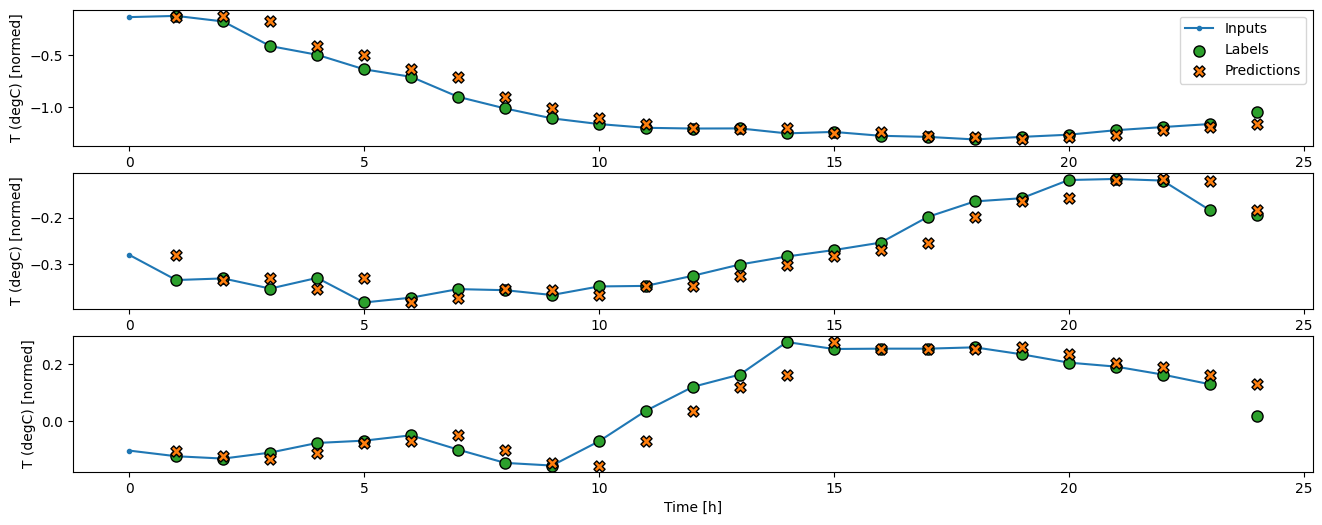

In [32]:
#En traçant les prédictions du modèle de base, notez qu'il s'agit simplement des étiquettes décalées d'une heure vers la droite
wide_window.plot(baseline)

#### Modèle linéaire de base : 
Une couche tf.keras.layers.Dense sans jeu d' activation est un modèle linéaire. La couche ne transforme que le dernier axe des données de (batch, time, inputs) en (batch, time, units) ; il est appliqué indépendamment à chaque élément sur les axes de batch et de time 

In [33]:
linear = tf.keras.Sequential([tf.keras.layers.Dense(units=1)])

In [34]:
history,elapsed = compile_and_fit(linear, single_step_window)
IPython.display.clear_output()
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)
print(elapsed)

439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0089 - mean_absolute_error: 0.0705
Elapsed for compile and fit =31.276100635528564s.


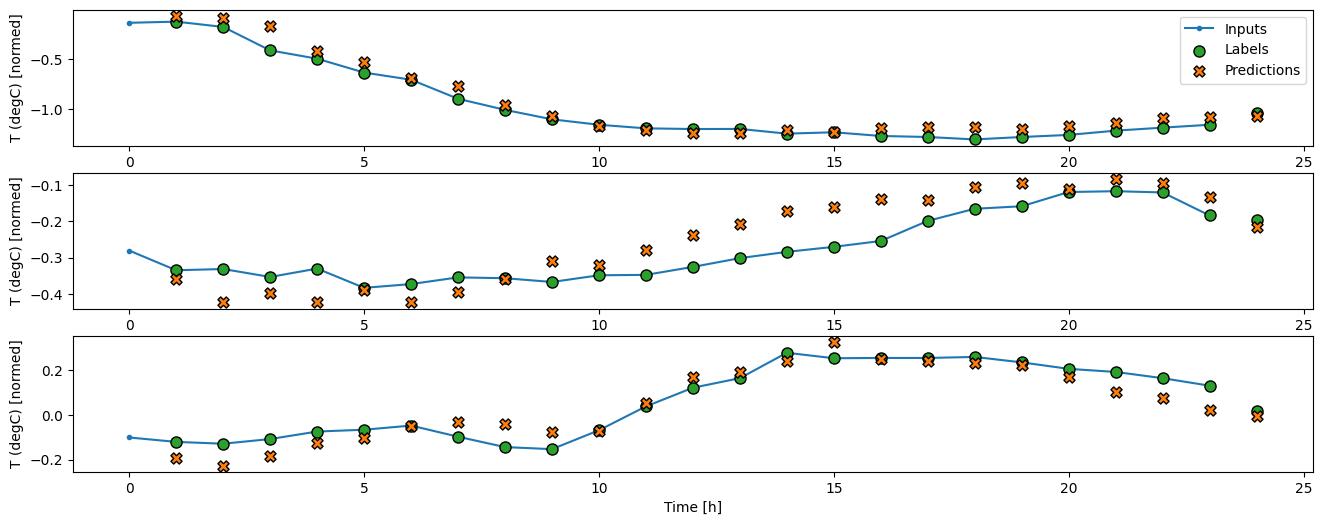

In [35]:
#On fait un plot du linear sur wide_window
wide_window.plot(linear)

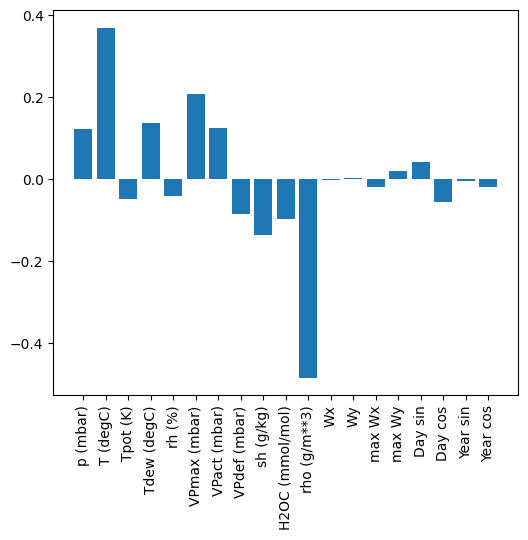

In [36]:
#Pour le modèle linéaire, les features étant normalisées, on peut extraire les poids de la couche qui correspoddent aux pentes des régresseurs
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [37]:
# Un modèle non léanire : plisueurs couches dense avec activation "relu" : 
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history,elapsed = compile_and_fit(dense, single_step_window)
IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)
print(elapsed)

439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0067 - mean_absolute_error: 0.0585
Elapsed for compile and fit =43.50211954116821s.


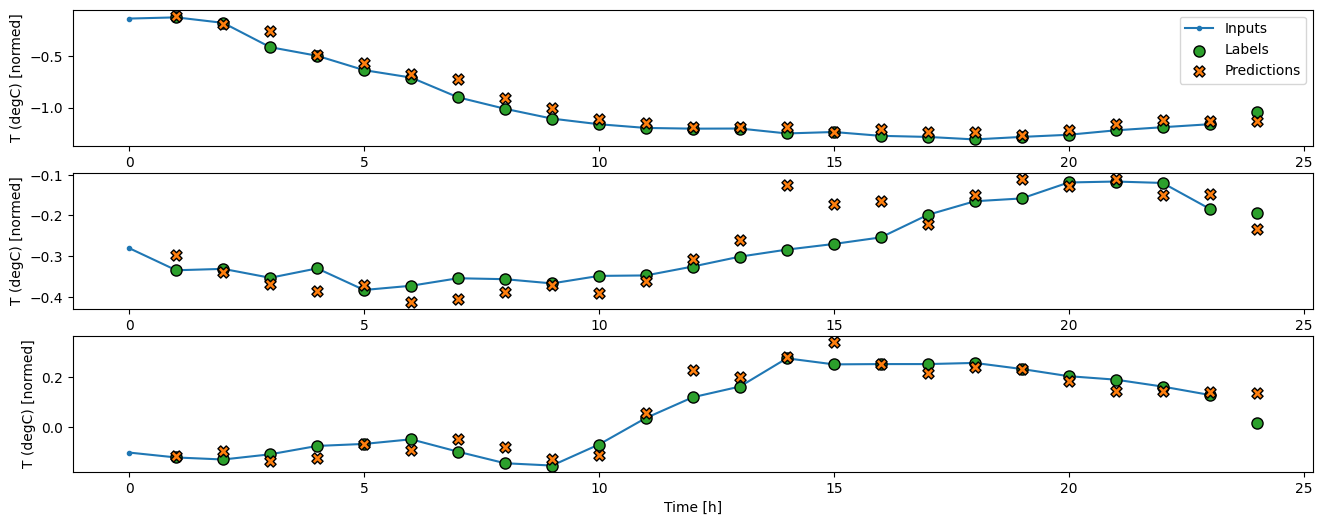

In [38]:
wide_window.plot(dense)

#### Modèles avec plusieurs pas de temps en entrée 

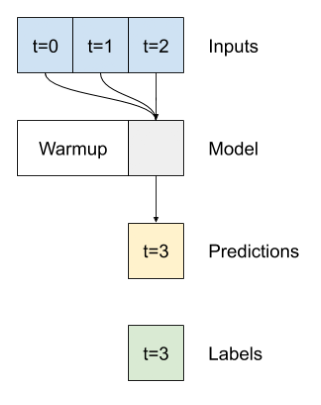

In [39]:
show_image('plusieurs_pas.png')

In [40]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

On peut entraîner un modèle dense sur une fenêtre à plusieurs étapes d'entrée en ajoutant un tf.keras.layers.Flatten comme première couche du modèle :

In [41]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [42]:
history,elapsed = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)
print(elapsed)

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0061 - mean_absolute_error: 0.0539
Elapsed for compile and fit =45.948981046676636s.


In [43]:
#Le principal inconvénient de cette approche est que le modèle résultant ne peut être exécuté que sur 
# #des fenêtres d'entrée ayant exactement cette forme.


print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 19)

ValueError:Exception encountered when calling Sequential.call().

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 57, but received input with shape (32, 456)

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 24, 19), dtype=float32)
  • training=None
  • mask=None


#### Réseaux de neurones à convolution
Une couche de convolution ( tf.keras.layers.Conv1D ) prend également plusieurs pas de temps en entrée pour chaque prédiction.

Ci-dessous, le même modèle que multi_step_dense , réécrit avec une convolution.

Notez les changements :

- Le tf.keras.layers.Flatten et le premier tf.keras.layers.Dense sont remplacés par un tf.keras.layers.Conv1D .
- Le tf.keras.layers.Reshape n'est plus nécessaire puisque la convolution conserve l'axe du temps dans sa sortie.

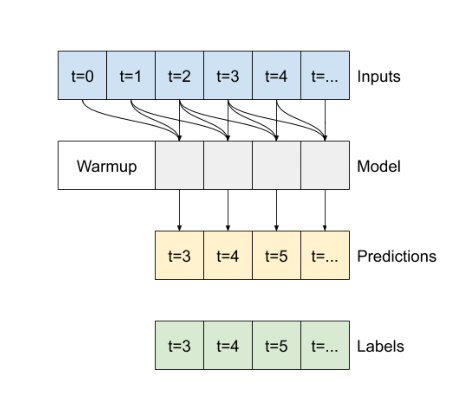

In [44]:
show_image('conv_model_1d.png')

In [45]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)


history,elapsed = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)
print(elapsed)

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068 - mean_absolute_error: 0.0597
Elapsed for compile and fit =19.121816635131836s.


In [46]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Notez que la sortie est plus courte que l'entrée. Pour que l'entraînement ou le traçage fonctionne, vous avez besoin que les étiquettes et la prédiction aient la même longueur. Construisez donc un WindowGenerator pour produire de larges fenêtres avec quelques pas de temps d'entrée supplémentaires afin que les longueurs d'étiquette et de prédiction correspondent :

In [47]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])
print("Wide conv window")
print(wide_conv_window)

print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']
Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


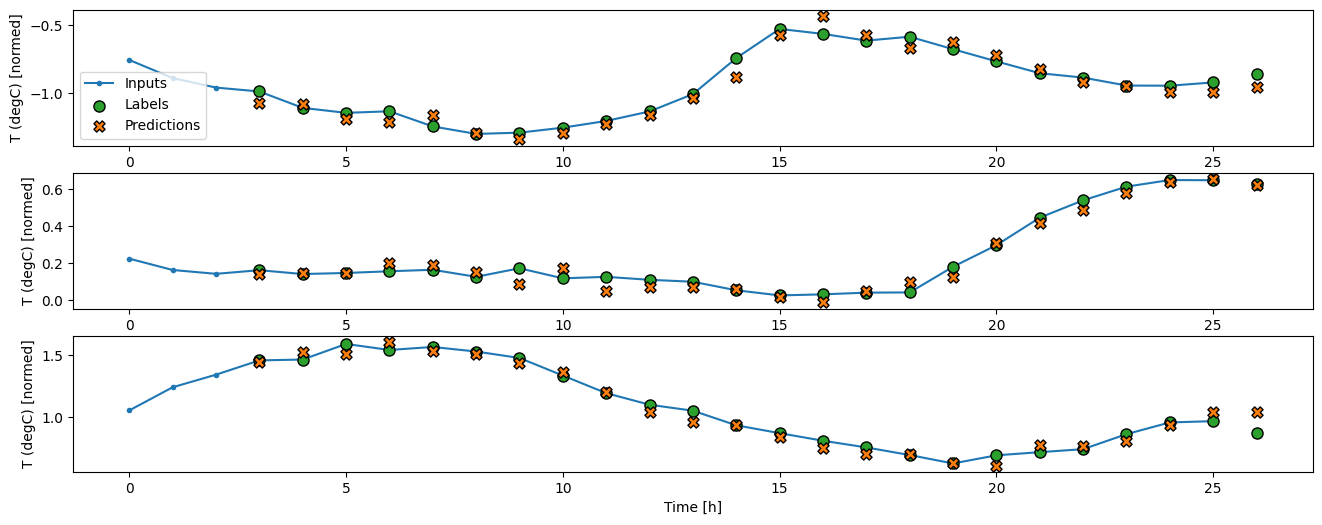

In [48]:
wide_conv_window.plot(conv_model)

#### RNN : réseau neuronal récurrent
Un réseau neuronal récurrent (RNN) est un type de réseau neuronal bien adapté aux données de séries chronologiques. Les RNN traitent une série chronologique étape par étape, en maintenant un état interne d'un pas de temps à l'autre.

Vous pouvez en savoir plus dans la génération de texte avec un didacticiel RNN et le guide Réseaux de neurones récurrents (RNN) avec Keras .

Dans ce didacticiel, vous utiliserez une couche RNN appelée Long Short-Term Memory ( tf.keras.layers.LSTM ).

Un argument de constructeur important pour toutes les couches Keras RNN, telles que tf.keras.layers.LSTM , est l'argument return_sequences . Ce paramètre peut configurer la couche de l'une des deux manières suivantes :

- Si False , la valeur par défaut, la couche ne renvoie que la sortie du dernier pas de temps, ce qui donne au modèle le temps de réchauffer son état interne avant de faire une seule prédiction
- Si True , la couche renvoie une sortie pour chaque entrée. Ceci est utile pour :
    - Empiler les couches RNN.
    - Entraîner un modèle sur plusieurs pas de temps simultanément.

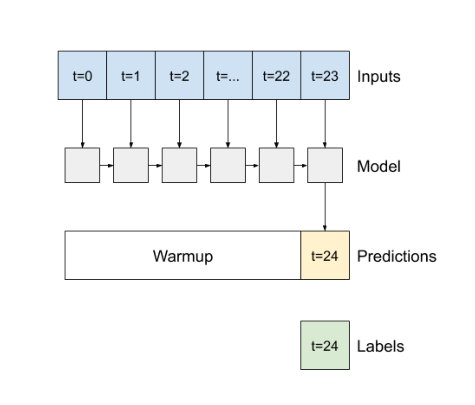

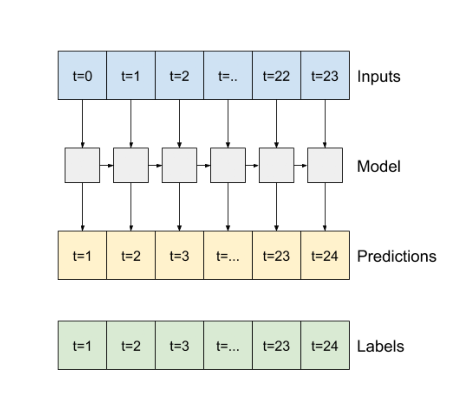

In [49]:
show_image("RNN_return_False.png")
show_image("RNN_return_True.png")

In [50]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


In [51]:
history,elapsed = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)
print(elapsed)

438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0056 - mean_absolute_error: 0.0517
Elapsed for compile and fit =209.74669861793518s.


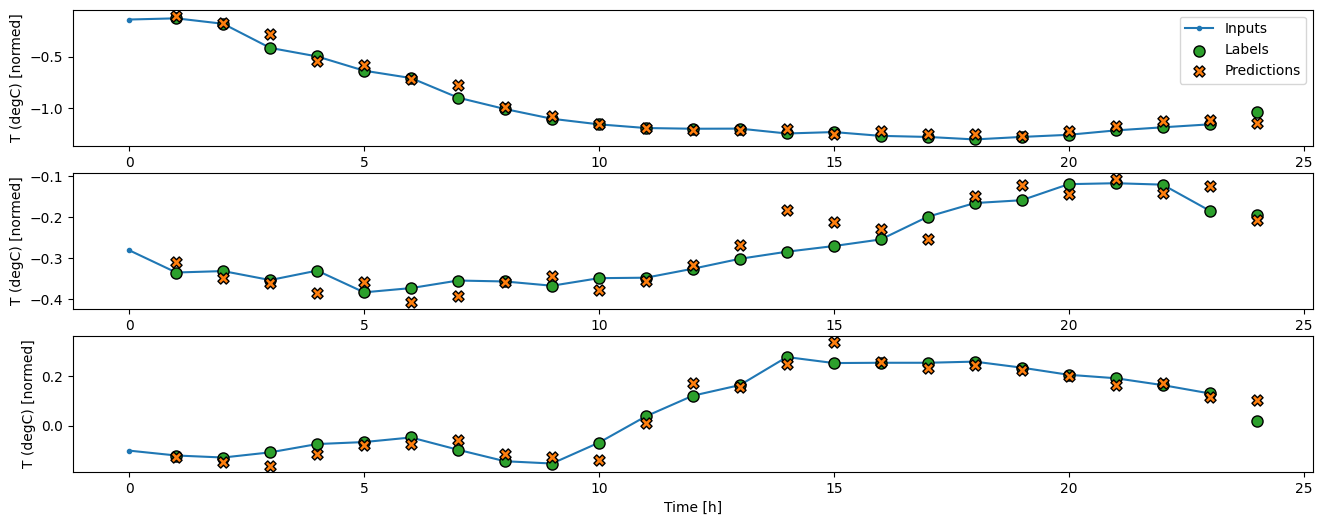

In [52]:
wide_window.plot(lstm_model)

#### Affichage des performances des modèles déjà entraînés : 

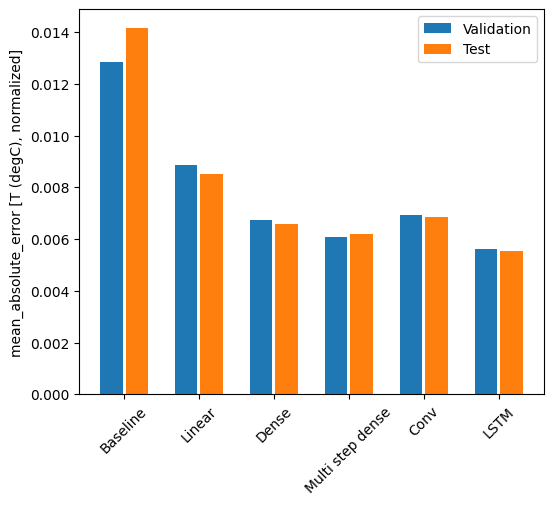

Baseline    : 0.0852
Linear      : 0.0688
Dense       : 0.0590
Multi step dense: 0.0554
Conv        : 0.0601
LSTM        : 0.0526


In [53]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = 0
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()
plt.show()

for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

#### Modèles multi-sorties
Jusqu'à présent, les modèles ont tous prédit une seule caractéristique de sortie, T (degC) , pour un seul pas de temps.

Tous ces modèles peuvent être convertis pour prédire plusieurs entités simplement en modifiant le nombre d'unités dans la couche de sortie et en ajustant les fenêtres d'apprentissage pour inclure toutes les entités dans les labels ( example_labels ):

In [54]:
multi_val_perf=dict()
multi_perf=dict()

In [55]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


2024-12-01 15:36:55.645749: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [56]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_perf['Baseline'] = baseline.evaluate(wide_window.val)
multi_perf['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0889 - mean_absolute_error: 0.1590


In [57]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])
history,elapsed = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
multi_val_perf['Dense'] = baseline.evaluate(wide_window.val)
multi_perf['Dense'] = baseline.evaluate(wide_window.test, verbose=0)
print(elapsed)

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0884 - mean_absolute_error: 0.1590
Elapsed for compile and fit =30.090006828308105s.


In [58]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history,elapsed= compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
multi_val_perf['LSTM'] = baseline.evaluate(wide_window.val)
multi_perf['LSTM'] = baseline.evaluate(wide_window.test, verbose=0)

print(elapsed)

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0881 - mean_absolute_error: 0.1586
Elapsed for compile and fit =218.9141561985016s.


### Connexions résiduelles
Le modèle de Baseline du précédent a profité du fait que la séquence ne change pas radicalement d'un pas de temps à l'autre. Chaque modèle formé dans ce didacticiel jusqu'à présent a été initialisé de manière aléatoire, puis a dû apprendre que la sortie est un petit changement par rapport au pas de temps précédent.

Bien que vous puissiez contourner ce problème avec une initialisation soignée, il est plus simple de l'intégrer à la structure du modèle.

Il est courant dans l'analyse des séries chronologiques de créer des modèles qui, au lieu de prédire la valeur suivante, prédisent comment la valeur changera au cours de l'étape suivante. De même, les réseaux résiduels - ou ResNets - dans l'apprentissage en profondeur font référence à des architectures où chaque couche ajoute au résultat cumulatif du modèle.

Essentiellement, cela initialise le modèle pour qu'il corresponde à la Baseline . Pour cette tâche, il aide les modèles à converger plus rapidement, avec des performances légèrement meilleures.

Cette approche peut être utilisée conjointement avec n'importe quel modèle présenté dans ce didacticiel.

Ici, il est appliqué au modèle LSTM, notez l'utilisation de tf.initializers.zeros pour s'assurer que les changements prédits initiaux sont faibles et ne surchargent pas la connexion résiduelle. Il n'y a pas de problème de rupture de symétrie pour les dégradés ici, puisque les zeros ne sont utilisés que sur la dernière couche.

In [59]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [60]:
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history,elapsed = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
multi_val_perf['LSTM_residual'] = baseline.evaluate(wide_window.val)
multi_perf['LSTM_residual'] = baseline.evaluate(wide_window.test, verbose=0)
print(elapsed)

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0886 - mean_absolute_error: 0.1591
Elapsed for compile and fit =132.4879322052002s.


Baseline       : 0.1638
Dense          : 0.1638
LSTM           : 0.1638
LSTM_residual  : 0.1638


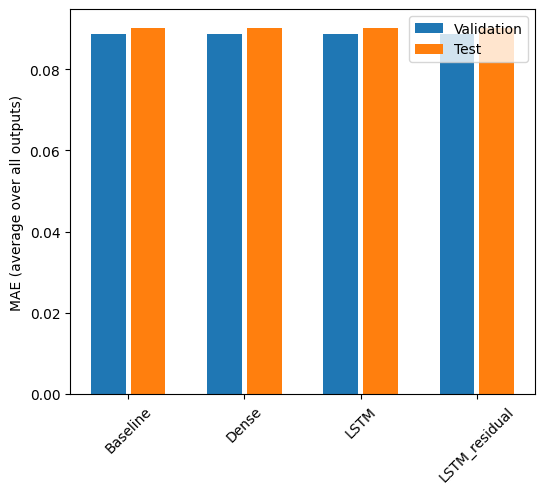

In [62]:
x = np.arange(len(multi_perf))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = 0
val_mae = [v[metric_index] for v in multi_val_perf.values()]
test_mae = [v[metric_index] for v in multi_perf.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_perf.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

for name, value in multi_perf.items():
    print(f'{name:15s}: {value[1]:0.4f}')

## Modèles multi-étapes
Les modèles à sortie unique et à sorties multiples dans les sections précédentes ont fait des prédictions à un seul pas de temps , une heure dans le futur.

Cette section examine comment étendre ces modèles pour faire des prédictions à plusieurs pas de temps .

Dans une prédiction en plusieurs étapes, le modèle doit apprendre à prédire une plage de valeurs futures. Ainsi, contrairement à un modèle à une seule étape, où un seul point futur est prédit, un modèle à plusieurs étapes prédit une séquence des valeurs futures.

Il existe deux approches approximatives pour cela:

Prédictions uniques où toute la série chronologique est prédite en une seule fois.
Prédictions autorégressives où le modèle ne fait que des prédictions en une seule étape et sa sortie est renvoyée en entrée.
Dans cette section, tous les modèles prédiront toutes les caractéristiques sur tous les pas de temps de sortie .

Pour le modèle à plusieurs étapes, les données d'apprentissage sont à nouveau constituées d'échantillons horaires. Cependant, ici, les modèles apprendront à prédire 24 heures dans le futur, étant donné 24 heures du passé.

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

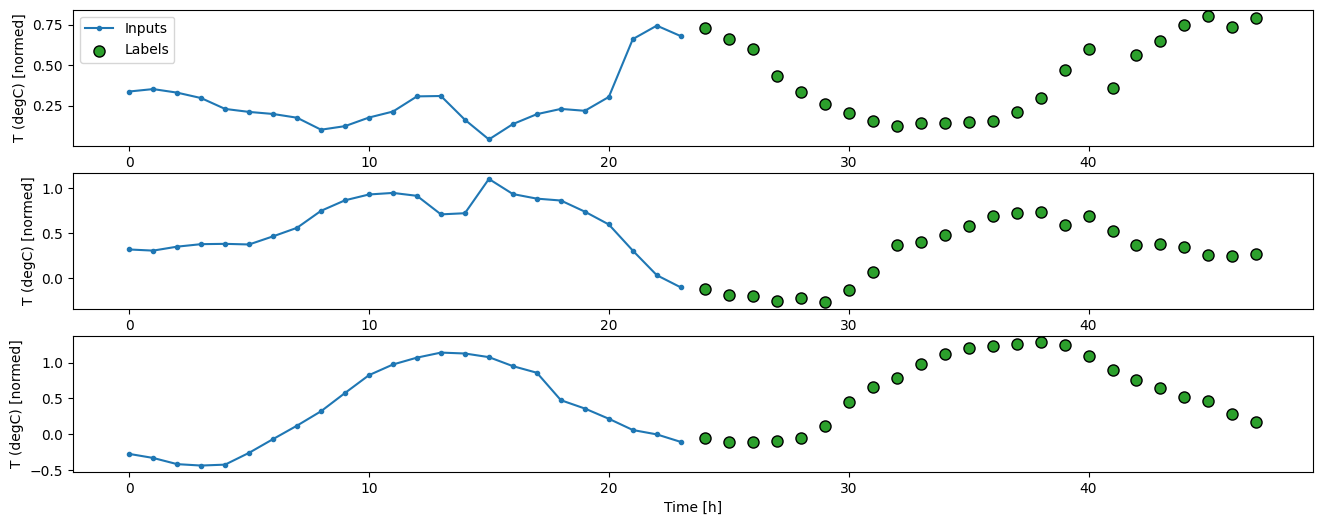

In [63]:
#Voici un objet Window qui génère ces tranches à partir du jeu de données :
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

#### Multi étapes base line : renvoie la dernière valeur uniquement

437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6322 - mean_absolute_error: 0.5025


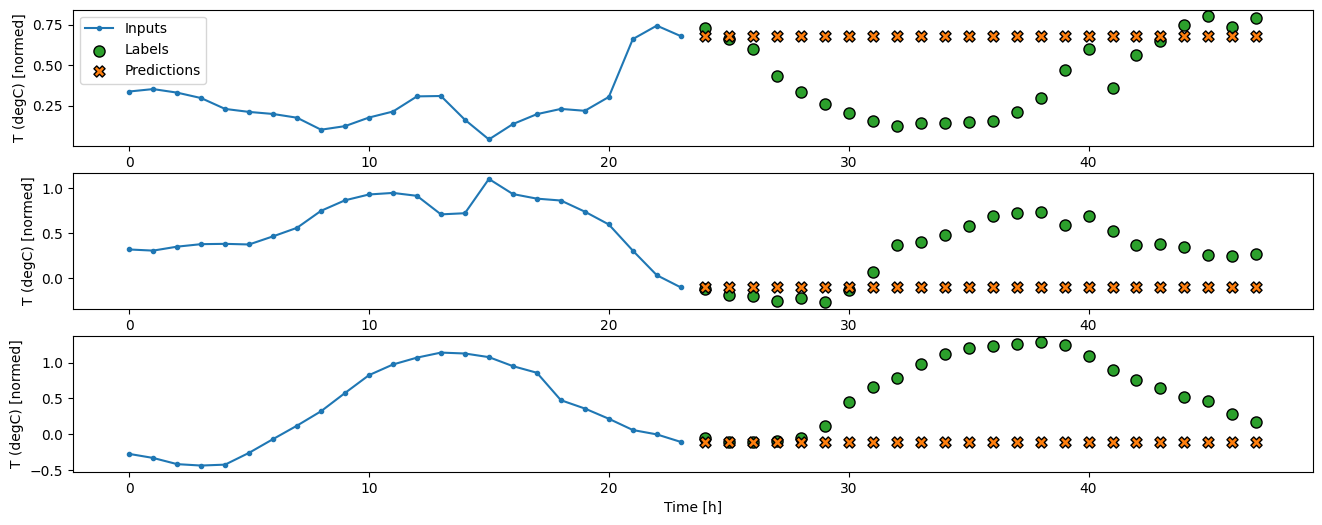

In [64]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

#### Multi étapes répétition: renvoie la dernière fenêtre reproduite à l'identique

437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4233 - mean_absolute_error: 0.3950


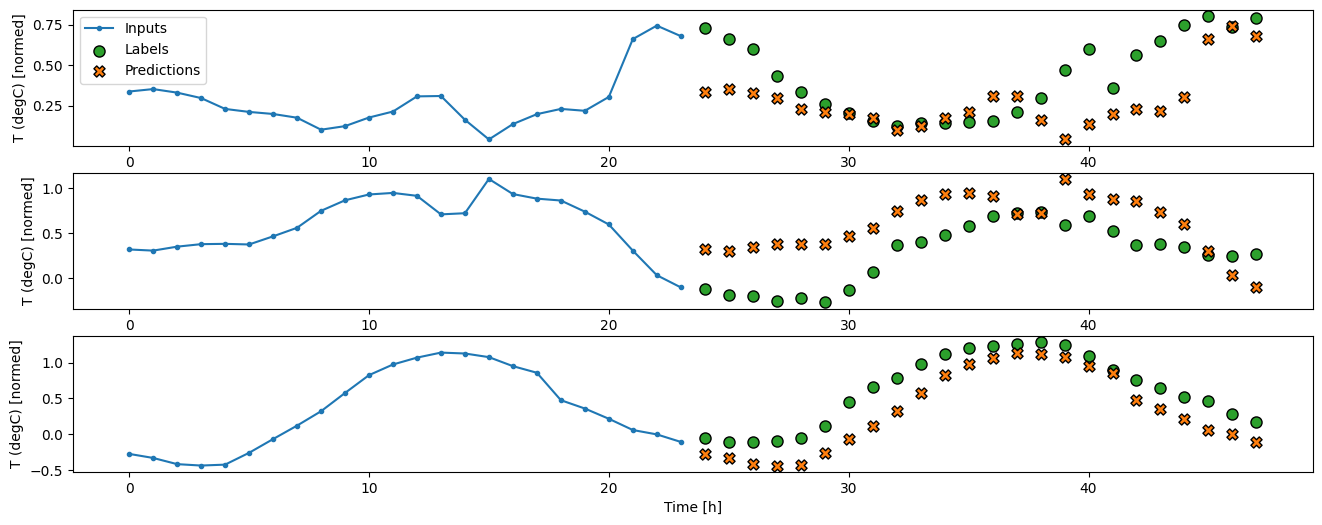

In [65]:
#Étant donné que cette tâche consiste à prédire 24 heures dans le futur, étant donné 24 heures du passé, 
# une autre approche simple consiste à répéter le jour précédent, en supposant que demain sera similaire :
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

#### Multi étapes monocoup : 
Une approche de haut niveau à ce problème consiste à utiliser un modèle "à un seul coup", où le modèle effectue la prédiction de la séquence entière en une seule étape.

Cela peut être implémenté efficacement en tant que tf.keras.layers.Dense avec OUT_STEPS*features unités de sortie. Le modèle a juste besoin de remodeler cette sortie selon les besoins (OUTPUT_STEPS, features) .

437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2572 - mean_absolute_error: 0.3066
Elapsed for compile and fit =55.44874143600464s.


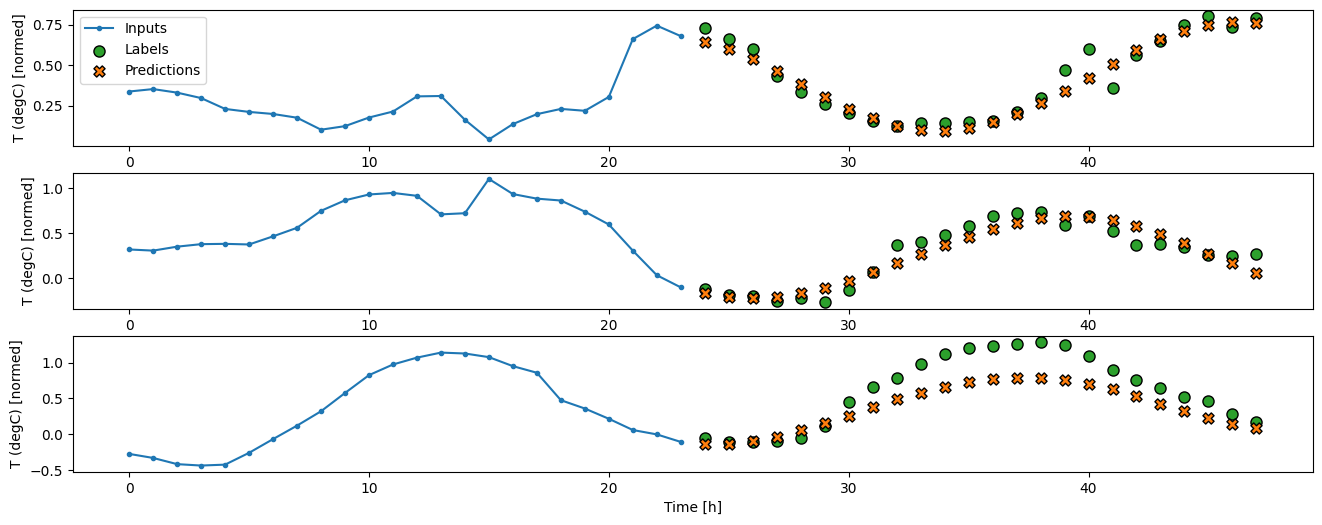

In [66]:
#Linéaire : mais n'exploite pas l'historique, n'utilise qu'une entrée sur "24"
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history,elapsed = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)
print(elapsed)

437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2210 - mean_absolute_error: 0.2825
Elapsed for compile and fit =92.20946145057678s.


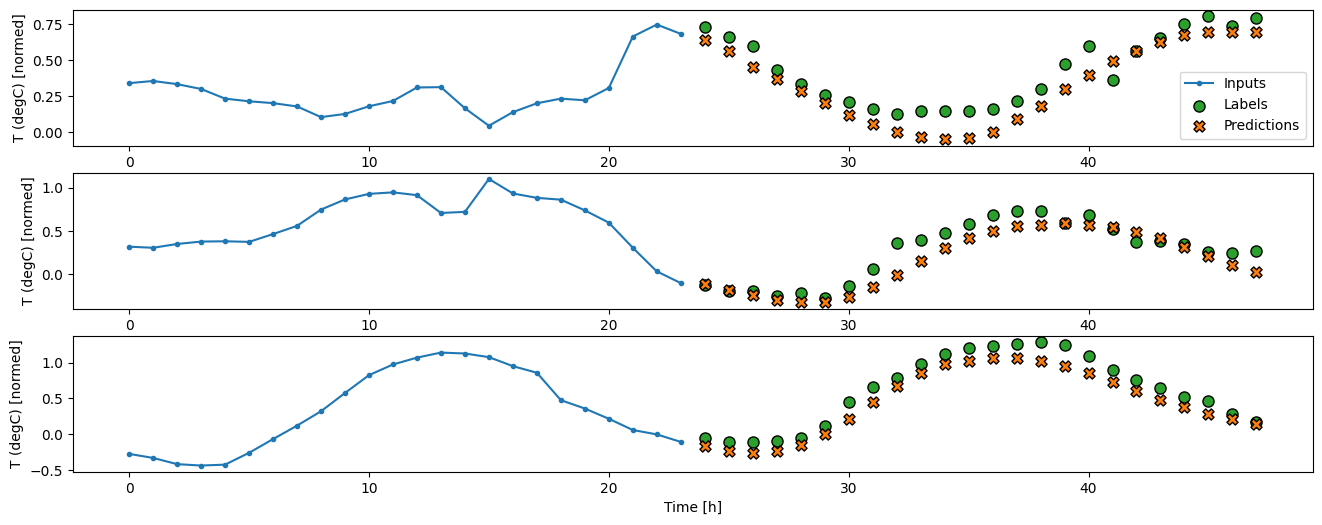

In [67]:
#dense : L'ajout d'un tf.keras.layers.Dense entre l'entrée et la sortie donne plus de puissance 
# au modèle linéaire, mais n'est toujours basé que sur un seul pas de temps d'entrée.
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history,elapsed = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)
print(elapsed)

437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2169 - mean_absolute_error: 0.2832
Elapsed for compile and fit =71.58509826660156s.


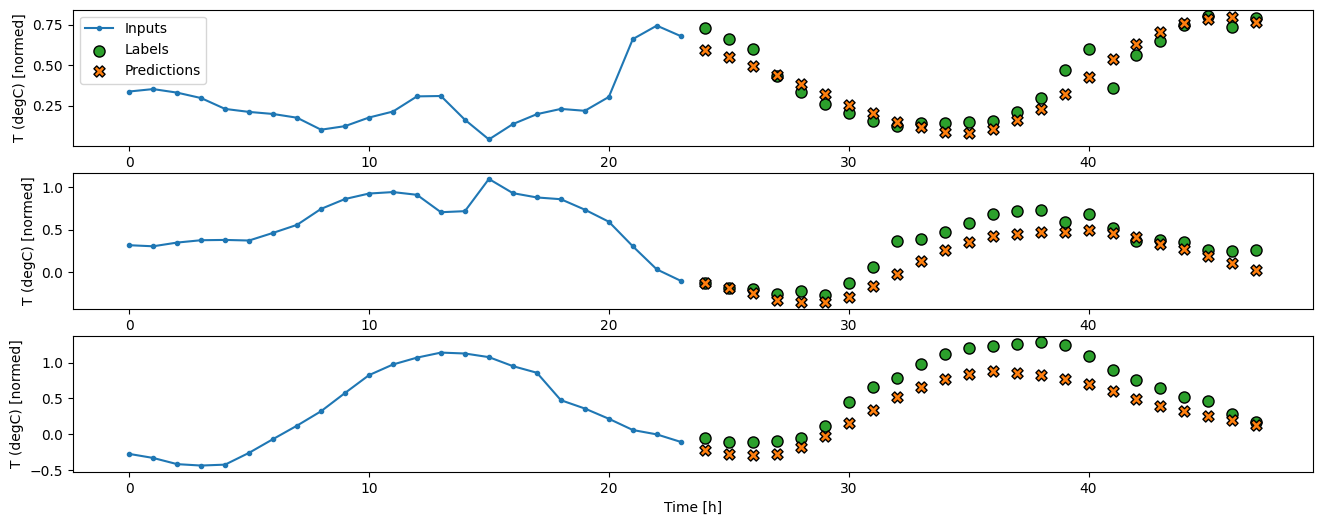

In [68]:
#CNN :Un modèle convolutif fait des prédictions basées sur un historique à largeur fixe, ce qui peut conduire à de meilleures performances 
# que le modèle dense car il peut voir comment les choses changent au fil du temps :
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history,elapsed = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model) 
print(elapsed)

437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2139 - mean_absolute_error: 0.2829
Elapsed for compile and fit =221.3363356590271s.


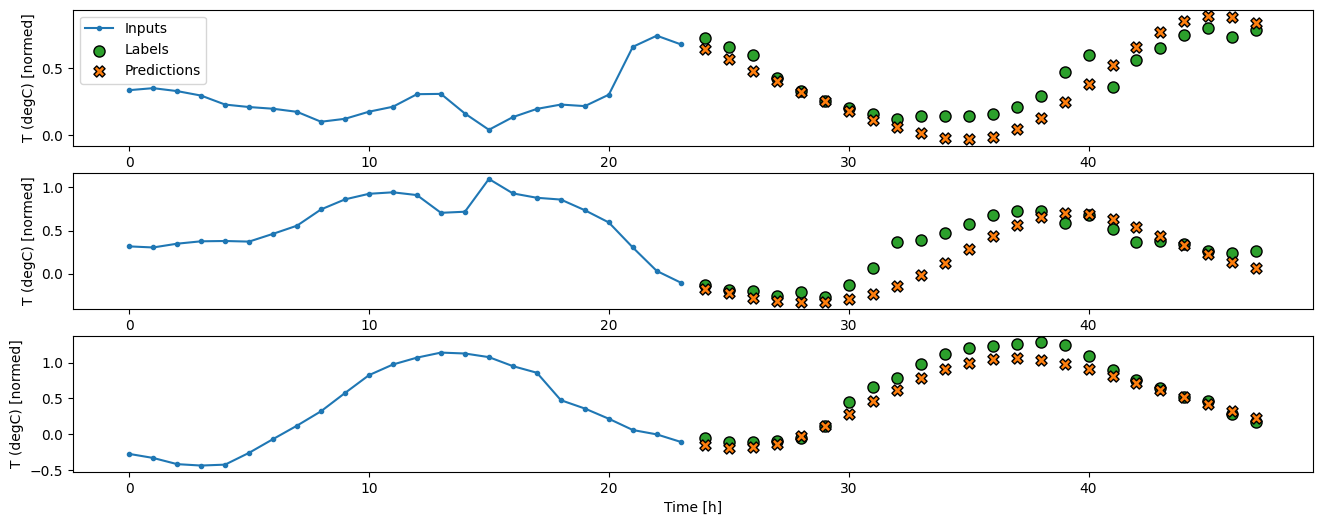

In [69]:
#RNN : Un modèle récurrent peut apprendre à utiliser un long historique d'entrées, si cela est pertinent pour 
# les prédictions que fait le modèle. Ici, le modèle accumulera l'état interne pendant 24 heures, avant de faire 
# une prédiction unique pour les 24 heures suivantes. 
# Dans ce format monocoup, le LSTM n'a besoin de produire une sortie qu'au dernier pas de temps, 
# donc définissez return_sequences=False dans tf.keras.layers.LSTM .

multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history,elapsed = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)
print(elapsed)

### Modèle autorégressif : 
Les modèles ci-dessus prédisent tous la séquence de sortie complète en une seule étape.

Dans certains cas, il peut être utile que le modèle décompose cette prédiction en pas de temps individuels. Ensuite, la sortie de chaque modèle peut être réintroduite en elle-même à chaque étape et des prédictions peuvent être faites en fonction de la précédente, comme dans le classique Génération de séquences avec des réseaux de neurones récurrents .

Un avantage évident de ce style de modèle est qu'il peut être configuré pour produire une sortie de longueur variable.

Vous pouvez prendre n'importe lequel des modèles à plusieurs sorties en une seule étape formés dans la première moitié de ce didacticiel et exécuter une boucle de rétroaction autorégressive, mais ici, vous vous concentrerez sur la création d'un modèle qui a été explicitement formé pour le faire.

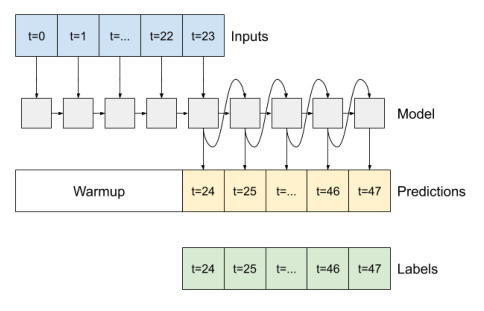

In [70]:
show_image('multistep_autoregressive.png')

Ce didacticiel ne construit qu'un modèle RNN autorégressif, mais ce modèle peut être appliqué à tout modèle conçu pour générer un seul pas de temps.

Le modèle aura la même forme de base que les modèles LSTM en une étape précédents : une couche tf.keras.layers.LSTM suivie d'une couche tf.keras.layers.Dense qui convertit les sorties de la couche LSTM en prédictions de modèle.

Un tf.keras.layers.LSTM est un tf.keras.layers.LSTMCell enveloppé dans le niveau supérieur tf.keras.layers.RNN qui gère l'état et les résultats de séquence pour vous (Consultez les réseaux de neurones récurrents (RNN) avec Keras guide pour plus de détails).

Dans ce cas, le modèle doit gérer manuellement les entrées pour chaque étape, il utilise tf.keras.layers.LSTMCell directement pour l'interface de niveau inférieur à pas de temps unique.

In [71]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [72]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

La première méthode dont ce modèle a besoin est une méthode de warmup pour initialiser son état interne en fonction des entrées. Une fois formé, cet état capturera les parties pertinentes de l'historique des entrées. Cela équivaut au modèle LSTM en une seule étape du précédent :

In [73]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [74]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

Avec l'état du RNN et une prédiction initiale, vous pouvez maintenant continuer à itérer le modèle en alimentant les prédictions à chaque étape en arrière comme entrée.

L'approche la plus simple pour collecter les prédictions de sortie consiste à utiliser une liste Python et un tf.stack après la boucle.

Remarque : Empiler une liste Python comme celle-ci ne fonctionne qu'avec une exécution impatiente, en utilisant Model.compile(..., run_eagerly=True) pour l'entraînement ou avec une sortie de longueur fixe. Pour une longueur de sortie dynamique, vous devez utiliser un tf.TensorArray au lieu d'une liste Python, et tf.range au lieu de Python range .

In [75]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [76]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


437/437 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.2258 - mean_absolute_error: 0.2995
Elapsed for compile and fit =250.15898489952087s.


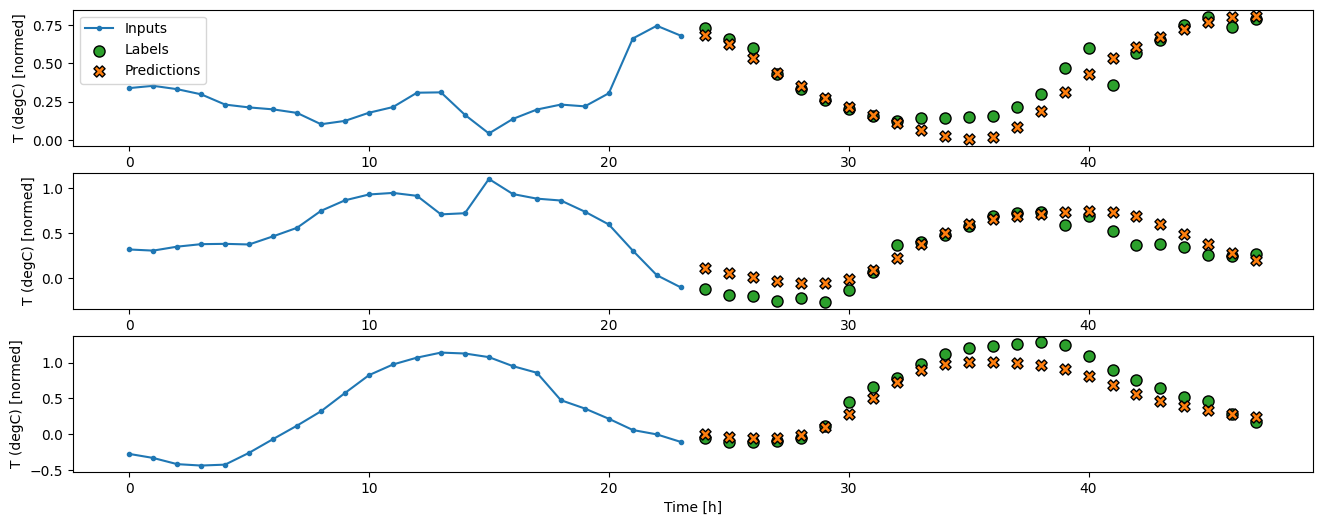

In [77]:
history,elapsed= compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)
print(elapsed)

Last    : 0.5157
Repeat  : 0.3774
Linear  : 0.2986
Dense   : 0.2751
Conv    : 0.2734
LSTM    : 0.2750
AR LSTM : 0.2922


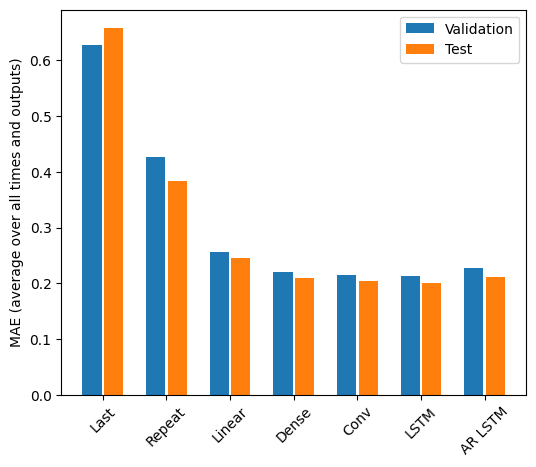

In [78]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = 0
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')